In [36]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use('classic')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
df = pd.read_csv("https://www.ndbc.noaa.gov/data/realtime2/46268.txt",delim_whitespace=True)
df.info()

df.drop(index=df.index[0],
        axis=0,
        inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2134 entries, 0 to 2133
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   #YY     2134 non-null   object
 1   MM      2134 non-null   object
 2   DD      2134 non-null   object
 3   hh      2134 non-null   object
 4   mm      2134 non-null   object
 5   WDIR    2134 non-null   object
 6   WSPD    2134 non-null   object
 7   GST     2134 non-null   object
 8   WVHT    2134 non-null   object
 9   DPD     2134 non-null   object
 10  APD     2134 non-null   object
 11  MWD     2134 non-null   object
 12  PRES    2134 non-null   object
 13  ATMP    2134 non-null   object
 14  WTMP    2134 non-null   object
 15  DEWP    2134 non-null   object
 16  VIS     2134 non-null   object
 17  PTDY    2134 non-null   object
 18  TIDE    2134 non-null   object
dtypes: object(19)
memory usage: 316.9+ KB


In [10]:
df['WVHT'] = df['WVHT'].astype(float)


In [11]:
df = df.reindex(index=df.index[::-1])

In [12]:
df

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
2133,2022,04,27,00,00,MM,MM,MM,0.7,17,7.0,206,MM,15.8,15.5,MM,MM,MM,MM
2132,2022,04,27,00,30,MM,MM,MM,0.7,17,7.5,203,MM,15.2,15.7,MM,MM,MM,MM
2131,2022,04,27,01,00,MM,MM,MM,0.7,17,7.4,191,MM,15.0,15.8,MM,MM,MM,MM
2130,2022,04,27,01,30,MM,MM,MM,0.7,17,7.4,204,MM,14.8,15.8,MM,MM,MM,MM
2129,2022,04,27,02,00,MM,MM,MM,0.7,17,7.6,205,MM,14.8,15.9,MM,MM,MM,MM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2022,06,10,22,00,MM,MM,MM,0.5,13,5.5,199,MM,20.4,20.7,MM,MM,MM,MM
4,2022,06,10,22,30,MM,MM,MM,0.5,13,4.5,196,MM,20.3,20.8,MM,MM,MM,MM
3,2022,06,10,23,00,MM,MM,MM,0.5,13,4.3,194,MM,19.7,20.7,MM,MM,MM,MM
2,2022,06,10,23,30,MM,MM,MM,0.5,13,4.2,199,MM,19.5,20.6,MM,MM,MM,MM


In [13]:
df.rename(columns={"#YY": "year",
                   "MM": "month",
                   "DD": "day",
                   "hh": "hour",
                   "mm": "minute"})



,year,month,day,hour,minute,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
2133,2022,04,27,00,00,MM,MM,MM,0.7,17,7.0,206,MM,15.8,15.5,MM,MM,MM,MM
2132,2022,04,27,00,30,MM,MM,MM,0.7,17,7.5,203,MM,15.2,15.7,MM,MM,MM,MM
2131,2022,04,27,01,00,MM,MM,MM,0.7,17,7.4,191,MM,15.0,15.8,MM,MM,MM,MM
2130,2022,04,27,01,30,MM,MM,MM,0.7,17,7.4,204,MM,14.8,15.8,MM,MM,MM,MM
2129,2022,04,27,02,00,MM,MM,MM,0.7,17,7.6,205,MM,14.8,15.9,MM,MM,MM,MM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2022,06,10,22,00,MM,MM,MM,0.5,13,5.5,199,MM,20.4,20.7,MM,MM,MM,MM
4,2022,06,10,22,30,MM,MM,MM,0.5,13,4.5,196,MM,20.3,20.8,MM,MM,MM,MM
3,2022,06,10,23,00,MM,MM,MM,0.5,13,4.3,194,MM,19.7,20.7,MM,MM,MM,MM
2,2022,06,10,23,30,MM,MM,MM,0.5,13,4.2,199,MM,19.5,20.6,MM,MM,MM,MM


In [14]:
df['WVHT']


2133    0.7
2132    0.7
2131    0.7
2130    0.7
2129    0.7
       ... 
5       0.5
4       0.5
3       0.5
2       0.5
1       0.6
Name: WVHT, Length: 2133, dtype: float64

This is markdown



In [21]:
train_y = torch.tensor(df['WVHT'].values.astype(np.float32))
train_x = torch.linspace(0,100,train_y.shape[0])

In [42]:
from gpytorch.kernels import RBFKernel, CosineKernel, ScaleKernel

In [51]:
covar_module = ScaleKernel(RBFKernel()) + ScaleKernel(CosineKernel())

#covar_module = ScaleKernel(CosineKernel())

In [52]:
# train_y.head()
# train_x.head()
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [53]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f    noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()


Iter 1/50 - Loss: 0.829    noise: 0.693
Iter 2/50 - Loss: 0.792    noise: 0.644
Iter 3/50 - Loss: 0.744    noise: 0.598
Iter 4/50 - Loss: 0.701    noise: 0.554
Iter 5/50 - Loss: 0.661    noise: 0.513
Iter 6/50 - Loss: 0.620    noise: 0.474
Iter 7/50 - Loss: 0.576    noise: 0.437
Iter 8/50 - Loss: 0.535    noise: 0.403
Iter 9/50 - Loss: 0.490    noise: 0.370
Iter 10/50 - Loss: 0.450    noise: 0.340
Iter 11/50 - Loss: 0.400    noise: 0.312
Iter 12/50 - Loss: 0.358    noise: 0.286
Iter 13/50 - Loss: 0.316    noise: 0.261
Iter 14/50 - Loss: 0.272    noise: 0.239
Iter 15/50 - Loss: 0.221    noise: 0.218
Iter 16/50 - Loss: 0.177    noise: 0.199
Iter 17/50 - Loss: 0.135    noise: 0.181
Iter 18/50 - Loss: 0.088    noise: 0.164
Iter 19/50 - Loss: 0.044    noise: 0.150
Iter 20/50 - Loss: -0.009    noise: 0.136
Iter 21/50 - Loss: -0.053    noise: 0.123
Iter 22/50 - Loss: -0.097    noise: 0.112
Iter 23/50 - Loss: -0.141    noise: 0.101
Iter 24/50 - Loss: -0.193    noise: 0.092
Iter 25/50 - Loss: -

In [54]:
#model.covar_module.base_kernel.period_length


In [55]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0,150,1000)
    observed_pred = likelihood(model(test_x))

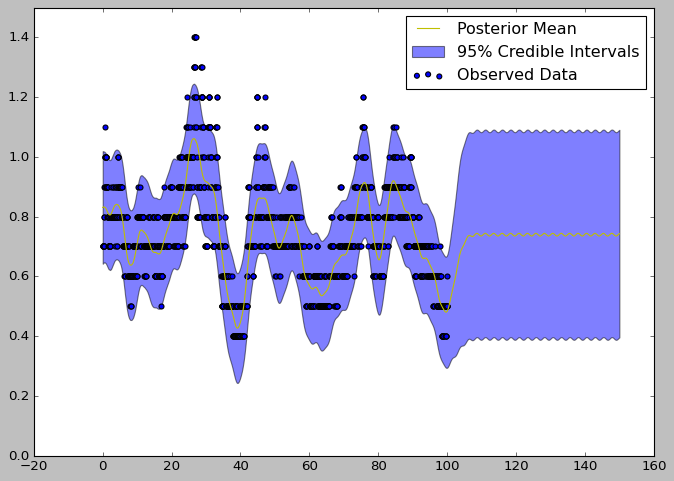

In [56]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # Plot training data as black stars
    ax.scatter(train_x.numpy(), train_y.numpy())
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'y')

    ax.set_ylim([0, 1.5])
    # ax.patch.set_facecolor('green')
    # ax.patch.set_alpha(.1)
    ax.legend(["Posterior Mean", "95% Credible Intervals", "Observed Data"])